# Time Series Forecasting Project – Electric Production

This merged notebook keeps your original work and adds missing steps: EDA, stationarity tests, train/test split, ARIMA order selection, evaluation metrics (RMSE, MAPE), and 12-step forecasting.

In [3]:
#importing the libraries

import pandas as pd
import numpy as np 
import seaborn as sns
import matplotlib.pyplot as plt

In [4]:
import warnings
warnings.filterwarnings('ignore')

from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

In [5]:
#Loading the dataset
elecom = pd.read_csv('Electric_Production.csv' , parse_dates=['DATE'] , index_col='DATE')

In [6]:
elecom = elecom[:len(elecom)-2]

## Exploratory Data Analysis (EDA)

We standardize the dataset to `df_inter` and plot trend + rolling statistics.

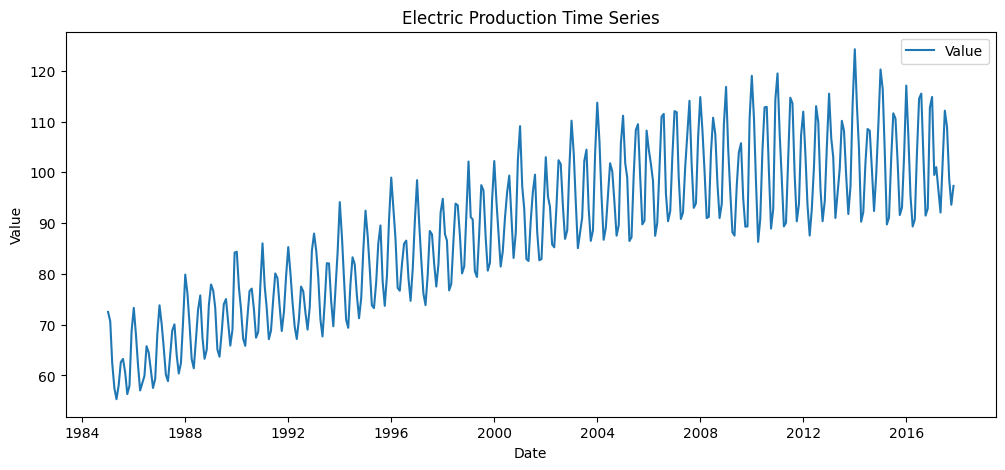

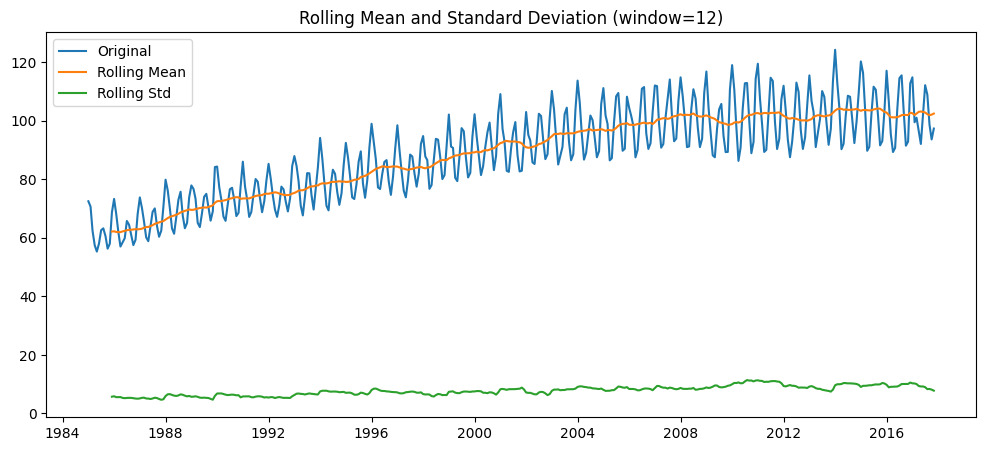

In [7]:

# Ensure we have a working DataFrame. Typical names in your notebook: elecom, elecom_inter
# Try to standardize to `df` which has a 'Value' column and a DateTime index.
try:
    df = elecom_inter.copy()
except NameError:
    try:
        df = elecom.copy()
    except NameError:
        # Try to construct df from loaded variables or reload
        import pandas as pd
        df = pd.read_csv('Electric_Production.csv', parse_dates=['DATE'], index_col='DATE')
        df = df[:len(df)-2]
# If column name is not 'Value', try to detect numeric column
if 'Value' not in df.columns:
    numeric_cols = df.select_dtypes(include='number').columns.tolist()
    if len(numeric_cols) >= 1:
        df = df[[numeric_cols[0]]].rename(columns={numeric_cols[0]:'Value'})
    else:
        raise ValueError('No numeric column found in the dataset.')

# Interpolate missing values if any
df_inter = df.copy()
df_inter['Value'] = df_inter['Value'].interpolate()

# Quick EDA plots
import matplotlib.pyplot as plt
plt.figure(figsize=(12,5))
plt.plot(df_inter['Value'], label='Value')
plt.title('Electric Production Time Series')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()
plt.show()

# Rolling statistics
roll_mean = df_inter['Value'].rolling(window=12).mean()
roll_std = df_inter['Value'].rolling(window=12).std()

plt.figure(figsize=(12,5))
plt.plot(df_inter['Value'], label='Original')
plt.plot(roll_mean, label='Rolling Mean')
plt.plot(roll_std, label='Rolling Std')
plt.title('Rolling Mean and Standard Deviation (window=12)')
plt.legend()
plt.show()


## Stationarity Testing

We run the Augmented Dickey-Fuller test on the original and the first-differenced series.

In [8]:

from statsmodels.tsa.stattools import adfuller

def adfuller_test(series, name='series'):
    print(f'ADF test for: {name}')
    result = adfuller(series.dropna())
    labels = ['ADF Statistic', 'p-value', '# Lags Used', '# Observations']
    for value, label in zip(result[:4], labels):
        print(f"{label}: {value}")
    if result[1] <= 0.05:
        print("=> Reject null hypothesis – data is stationary")
    else:
        print("=> Fail to reject null hypothesis – data is non-stationary")
    print('')

adfuller_test(df_inter['Value'], 'Original Series')
# If non-stationary, show first difference test
df_diff = df_inter['Value'].diff().dropna()
adfuller_test(df_diff, '1st Difference')


ADF test for: Original Series
ADF Statistic: -2.5687979469516082
p-value: 0.09961908381488799
# Lags Used: 15
# Observations: 379
=> Fail to reject null hypothesis – data is non-stationary

ADF test for: 1st Difference
ADF Statistic: -7.110409750028388
p-value: 3.95255687931337e-10
# Lags Used: 14
# Observations: 379
=> Reject null hypothesis – data is stationary



## ACF and PACF (on differenced series)

<Figure size 1000x400 with 0 Axes>

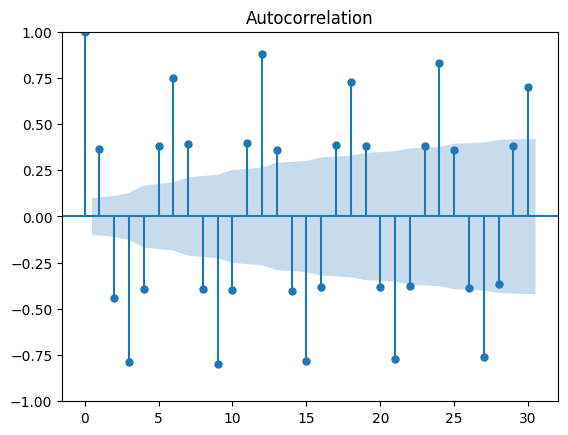

<Figure size 1000x400 with 0 Axes>

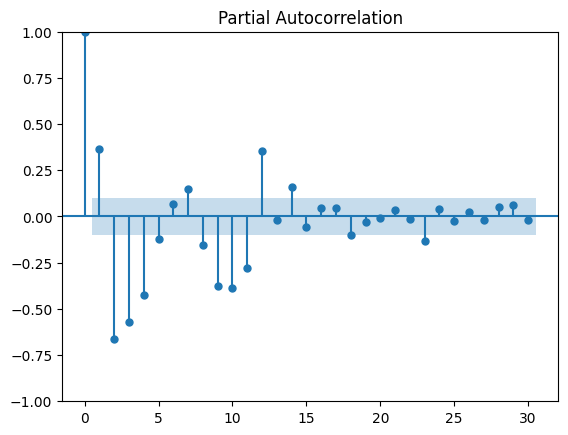

In [9]:

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
plt.figure(figsize=(10,4))
plot_acf(df_diff, lags=30)
plt.show()

plt.figure(figsize=(10,4))
plot_pacf(df_diff, lags=30, method='ywm')
plt.show()


## Train/Test Split

In [10]:

# Train/test split (80/20) on the differenced series
train_size = int(len(df_diff) * 0.8)
train, test = df_diff[:train_size], df_diff[train_size:]
print(f"Train size: {len(train)}, Test size: {len(test)}")


Train size: 315, Test size: 79


## ARIMA Order Selection (grid search)

In [13]:
import warnings
import numpy as np
from statsmodels.tsa.arima.model import ARIMA

best_aic = np.inf
best_order = None
best_mdl = None

p_range = range(0, 4)
d_range = range(0, 3)
q_range = range(0, 4)

# Clean the series
series_for_model = df_inter['Value'].dropna()

print('Searching for best ARIMA(p,d,q) by AIC...')
for p in p_range:
    for d in d_range:
        for q in q_range:
            try:
                with warnings.catch_warnings():
                    warnings.filterwarnings("ignore")
                    mdl = ARIMA(series_for_model, order=(p, d, q))
                    res = mdl.fit()
                if res.aic < best_aic:
                    best_aic = res.aic
                    best_order = (p, d, q)
                    best_mdl = res
            except Exception:
                continue

if best_order:
    print(f'Best ARIMA order: {best_order} with AIC: {best_aic}')
else:
    print("No ARIMA model could be successfully fitted.")


Searching for best ARIMA(p,d,q) by AIC...
Best ARIMA order: (3, 1, 2) with AIC: 2092.419166536497


## Fit Selected ARIMA Model and Evaluate

                               SARIMAX Results                                
Dep. Variable:                  Value   No. Observations:                  315
Model:                 ARIMA(3, 1, 2)   Log Likelihood                -813.504
Date:                Tue, 12 Aug 2025   AIC                           1639.008
Time:                        16:40:48   BIC                           1661.505
Sample:                    01-01-1985   HQIC                          1647.997
                         - 03-01-2011                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8753      0.059     14.867      0.000       0.760       0.991
ar.L2         -0.8768      0.058    -14.997      0.000      -0.991      -0.762
ar.L3         -0.1228      0.059     -2.092      0.0

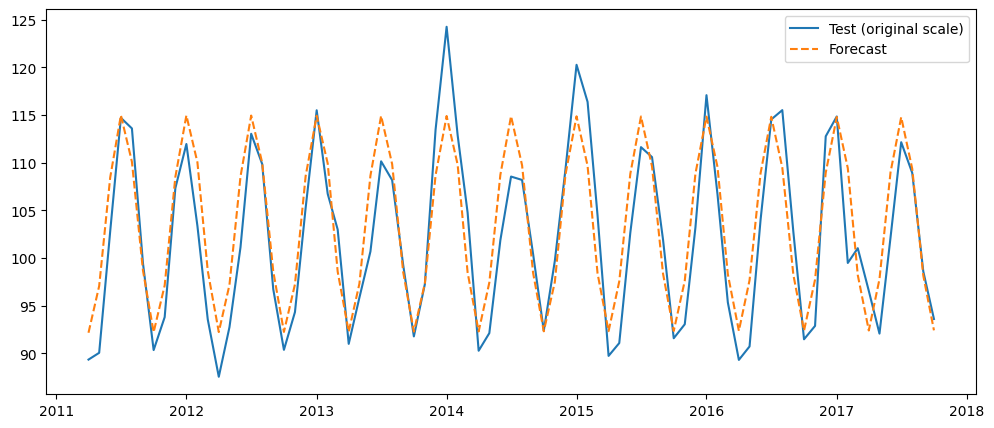

RMSE: 4.2445, MAPE: 3.45%


In [15]:

# Fit best model on training portion of the original series (using the same d)
if best_order is None:
    raise RuntimeError("No ARIMA model was successfully fit during grid search.")

p,d,q = best_order
# Fit on training segment of the original (not differenced) series to allow forecasting in original scale
train_orig = df_inter['Value'][:train_size]
test_orig = df_inter['Value'][train_size:train_size+len(test)]

model = ARIMA(train_orig, order=(p,d,q))
model_fit = model.fit()
print(model_fit.summary())

# Forecast the differenced-length horizon, then compare appropriately.
n_steps = len(test)
forecast = model_fit.forecast(steps=n_steps)

# If d>0 and the model was fit on original series, forecast is already on original scale.
# Compare forecast vs test_orig
import matplotlib.pyplot as plt
plt.figure(figsize=(12,5))
plt.plot(test_orig.index, test_orig, label='Test (original scale)')
plt.plot(test_orig.index, forecast, label='Forecast', linestyle='--')
plt.legend()
plt.show()

from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
rmse = mean_squared_error(test_orig, forecast) ** 0.5

mape = mean_absolute_percentage_error(test_orig, forecast)
print(f"RMSE: {rmse:.4f}, MAPE: {mape:.2%}")


## Forecasting 12 Periods Ahead

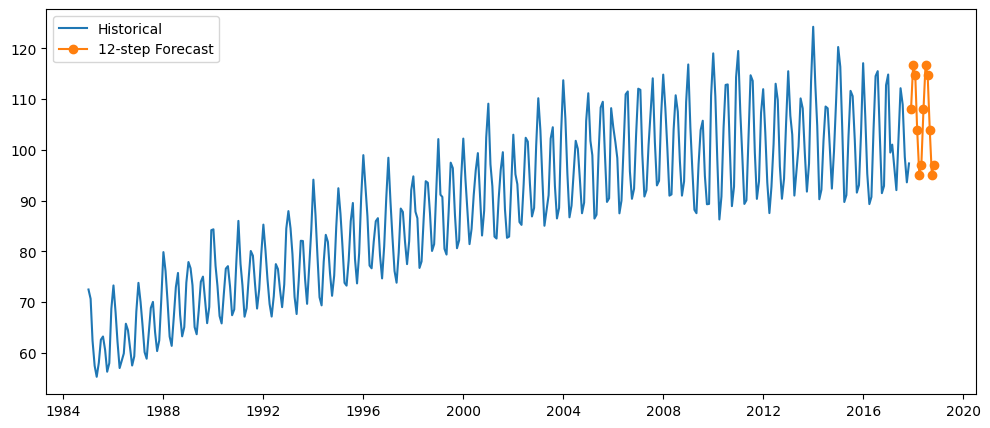

In [16]:

# Refit model on full series and forecast 12 periods ahead
final_model = ARIMA(df_inter['Value'], order=best_order).fit()
future_steps = 12
future_forecast = final_model.forecast(steps=future_steps)

plt.figure(figsize=(12,5))
plt.plot(df_inter['Value'], label='Historical')
# Create future index for plotting
last_idx = df_inter.index[-1]
# Attempt to build monthly periods if index is monthly, otherwise use integer range
try:
    future_index = pd.date_range(start=last_idx, periods=future_steps+1, freq='MS')[1:]
except Exception:
    future_index = range(len(df_inter), len(df_inter)+future_steps)

plt.plot(future_index, future_forecast, marker='o', label='12-step Forecast')
plt.legend()
plt.show()
